In [1]:
# % matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import cv2
import numpy as np
from torchinfo import summary
from torch.utils.data import DataLoader
import time

In [2]:
import os

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, transform=None, target_transform=None):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.fname_list = None
        self.base_dir = base_dir
        self.target_transform = target_transform
        self.create_fname_list()
        self.img_labels = self.fname_list

    def create_fname_list(self):
        self.fname_list = os.listdir(os.path.join(self.base_dir, 'image'))
        self.fname_list = list(filter(lambda x: x.find("tif") != -1, self.fname_list))

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # TODO: refactor
        img_path = os.path.join(self.base_dir, 'image', self.fname_list[idx])
        image = plt.imread(img_path)
        p2 = np.array(np.zeros((3, 256, 256)))
        p2[0, ...] = image[..., 0]
        p2[1, ...] = image[..., 1]
        p2[2, ...] = image[..., 2]
        label_path = os.path.join(self.base_dir, 'label', self.fname_list[idx])
        image_label = plt.imread(label_path)
        label = np.divide(image_label[..., 0], 255).astype(int)
        lab = np.array(np.zeros((1, 256, 256)))
        lab[0, :, :] = label
        tor = torch.from_numpy(p2)
        feature = self.normalize_image(tor)

        return feature, torch.from_numpy(lab).float()



In [3]:
def get_model():
    model = torchvision.models.segmentation.fcn_resnet50(True)
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    model.aux_classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    return model

In [4]:
model = get_model()
device = torch.device(f'cuda:{0}')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=1e-4, weight_decay=1e-3)
summary(model=model, input_size=(5, 3, 256, 256))

Layer (type:depth-idx)                        Output Shape              Param #
FCN                                           [5, 1, 256, 256]          --
├─IntermediateLayerGetter: 1-1                [5, 2048, 32, 32]         --
│    └─Conv2d: 2-1                            [5, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                       [5, 64, 128, 128]         128
│    └─ReLU: 2-3                              [5, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                         [5, 64, 64, 64]           --
│    └─Sequential: 2-5                        [5, 256, 64, 64]          --
│    │    └─Bottleneck: 3-1                   [5, 256, 64, 64]          75,008
│    │    └─Bottleneck: 3-2                   [5, 256, 64, 64]          70,400
│    │    └─Bottleneck: 3-3                   [5, 256, 64, 64]          70,400
│    └─Sequential: 2-6                        [5, 512, 32, 32]          --
│    │    └─Bottleneck: 3-4                   [5, 512, 32, 32]          379,392

In [5]:
### Table for results
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'

In [6]:

batch_size = 32
my_data_set_test = DataLoader(CustomImageDataset('images/segmentation/test'), batch_size, num_workers=4)
my_data_set_train = DataLoader(CustomImageDataset('images/segmentation/train'), batch_size, num_workers=4)

In [7]:
@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    model.eval()
    for image, target in loader:
        image, target = image.to(device), target.float().to(device)
        output = model(image)['out']
        loss = loss_fn(output, target)
        losses.append(loss.item())
        
    return np.array(losses).mean()

In [8]:
bce_fn = nn.BCEWithLogitsLoss()

print(header)
EPOCHES = 20

for epoch in range(1, EPOCHES + 1):
    losses = []
    start_time = time.time()
    model.train()
    for image, target in my_data_set_train:
        image, target = image.to(device), target.float().to(device)
        optimizer.zero_grad()
        output = model(image)['out']
        loss = bce_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    vloss = validation(model, my_data_set_test, bce_fn)
    print(raw_line.format(epoch, np.array(losses).mean(), vloss,
                              (time.time()-start_time)/60**1))
    losses = []


        Train | Valid
Epoch |  Loss |  Loss | Time, m

     1│  0.393│  0.416│  0.54
     2│  0.228│  0.179│  0.52
     3│  0.177│  0.147│  0.52
     4│  0.141│  0.127│  0.53
     5│  0.118│  0.108│  0.53
     6│  0.102│  0.099│  0.52
     7│  0.090│  0.093│  0.53
     8│  0.080│  0.087│  0.53
     9│  0.074│  0.084│  0.53
    10│  0.069│  0.082│  0.53
    11│  0.065│  0.092│  0.53
    12│  0.063│  0.085│  0.52
    13│  0.058│  0.078│  0.53
    14│  0.055│  0.073│  0.52
    15│  0.051│  0.072│  0.52
    16│  0.049│  0.071│  0.52
    17│  0.047│  0.072│  0.53
    18│  0.044│  0.078│  0.53
    19│  0.042│  0.073│  0.52
    20│  0.040│  0.072│  0.52


In [9]:
torch.save(model.state_dict(), "segmentationtest.pt")

In [10]:
my_data_set_test = DataLoader(CustomImageDataset('images/segmentation/test'), batch_size, num_workers=4)
my_data_set_train = DataLoader(CustomImageDataset('images/segmentation/train'), batch_size, num_workers=4)

In [25]:
train_iter = my_data_set_train.__iter__()
test_iter = my_data_set_test.__iter__()

In [26]:
itrain, ltrain = next(train_iter)
itest, ltest = next(test_iter)

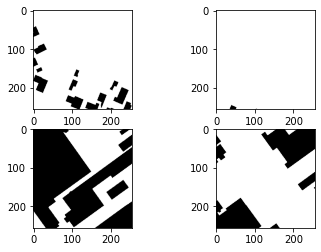

In [33]:
plt.subplot(2, 2, 1)
plt.imshow(ltrain[0][0], cmap="Greys")
plt.subplot(2, 2, 2)
plt.imshow(ltrain[1][0], cmap="Greys")
plt.subplot(2, 2, 3)
plt.imshow(ltest[0][0], cmap="Greys")
plt.subplot(2, 2, 4)
plt.imshow(ltest[1][0], cmap="Greys")

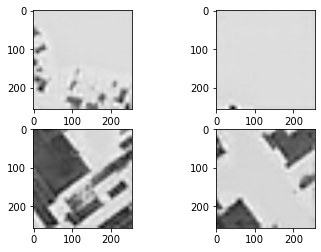

In [34]:
plt.subplot(2, 2, 1)
plt.imshow(np.array(model(itrain.to(device))['out'].cpu().detach().numpy())[0][0], cmap="Greys")
plt.subplot(2, 2, 2)
plt.imshow(np.array(model(itrain.to(device))['out'].cpu().detach().numpy())[1][0], cmap="Greys")
plt.subplot(2, 2, 3)
plt.imshow(np.array(model(itest.to(device))['out'].cpu().detach().numpy())[0][0], cmap="Greys")
plt.subplot(2, 2, 4)
plt.imshow(np.array(model(itest.to(device))['out'].cpu().detach().numpy())[1][0], cmap="Greys")